# Segmentación

In [1]:
import random
import gc

import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

import fastai.vision.all as fv

from Layers import num_params, Normalize

In [2]:
path = fv.untar_data(fv.URLs.CAMVID)

In [3]:
path.ls()

(#4) [Path('/home/mraggi/.fastai/data/camvid/images'),Path('/home/mraggi/.fastai/data/camvid/labels'),Path('/home/mraggi/.fastai/data/camvid/codes.txt'),Path('/home/mraggi/.fastai/data/camvid/valid.txt')]

In [4]:
img_path, lbl_path, codes_txt, valid_txt = path.ls()

In [5]:
!head {codes_txt}

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence


In [6]:
img_path.ls()

(#702) [Path('/home/mraggi/.fastai/data/camvid/images/0001TP_009990.png'),Path('/home/mraggi/.fastai/data/camvid/images/0001TP_010050.png'),Path('/home/mraggi/.fastai/data/camvid/images/0006R0_f03510.png'),Path('/home/mraggi/.fastai/data/camvid/images/Seq05VD_f02580.png'),Path('/home/mraggi/.fastai/data/camvid/images/0001TP_009270.png'),Path('/home/mraggi/.fastai/data/camvid/images/0016E5_01860.png'),Path('/home/mraggi/.fastai/data/camvid/images/0016E5_04350.png'),Path('/home/mraggi/.fastai/data/camvid/images/0016E5_04680.png'),Path('/home/mraggi/.fastai/data/camvid/images/0006R0_f03720.png'),Path('/home/mraggi/.fastai/data/camvid/images/0016E5_07200.png')...]

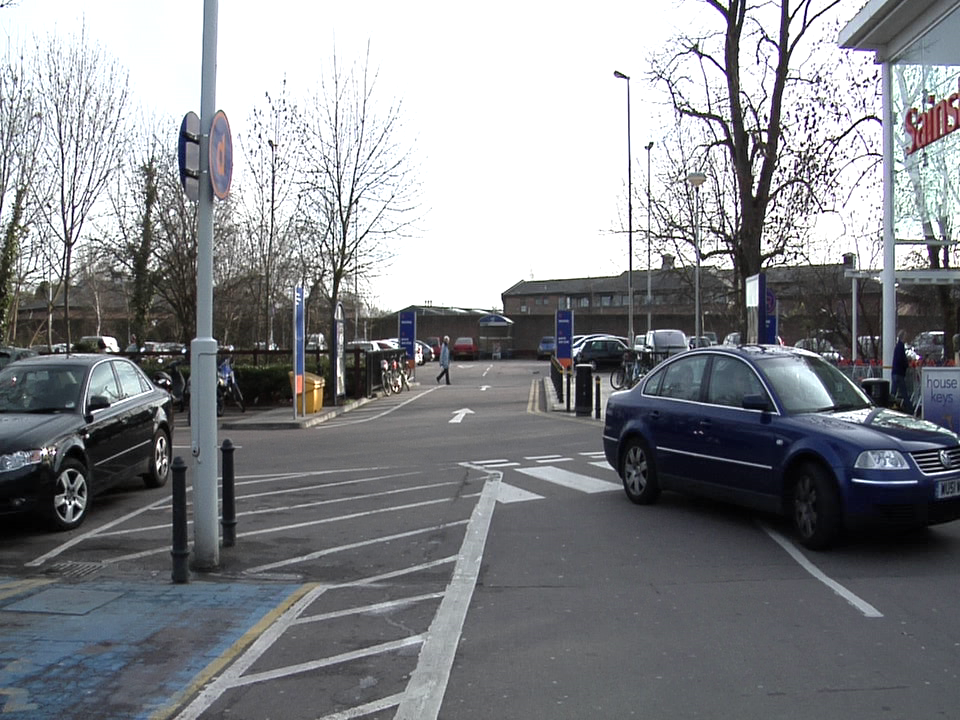

In [7]:
im = img_path.ls()[2]
fv.PILImage.create(im)

In [8]:
lbl_path.ls()

(#701) [Path('/home/mraggi/.fastai/data/camvid/labels/0001TP_010350_P.png'),Path('/home/mraggi/.fastai/data/camvid/labels/0016E5_00720_P.png'),Path('/home/mraggi/.fastai/data/camvid/labels/0006R0_f01200_P.png'),Path('/home/mraggi/.fastai/data/camvid/labels/0016E5_01740_P.png'),Path('/home/mraggi/.fastai/data/camvid/labels/0001TP_010170_P.png'),Path('/home/mraggi/.fastai/data/camvid/labels/0006R0_f02370_P.png'),Path('/home/mraggi/.fastai/data/camvid/labels/0001TP_009000_P.png'),Path('/home/mraggi/.fastai/data/camvid/labels/0001TP_009240_P.png'),Path('/home/mraggi/.fastai/data/camvid/labels/Seq05VD_f03870_P.png'),Path('/home/mraggi/.fastai/data/camvid/labels/0016E5_05280_P.png')...]

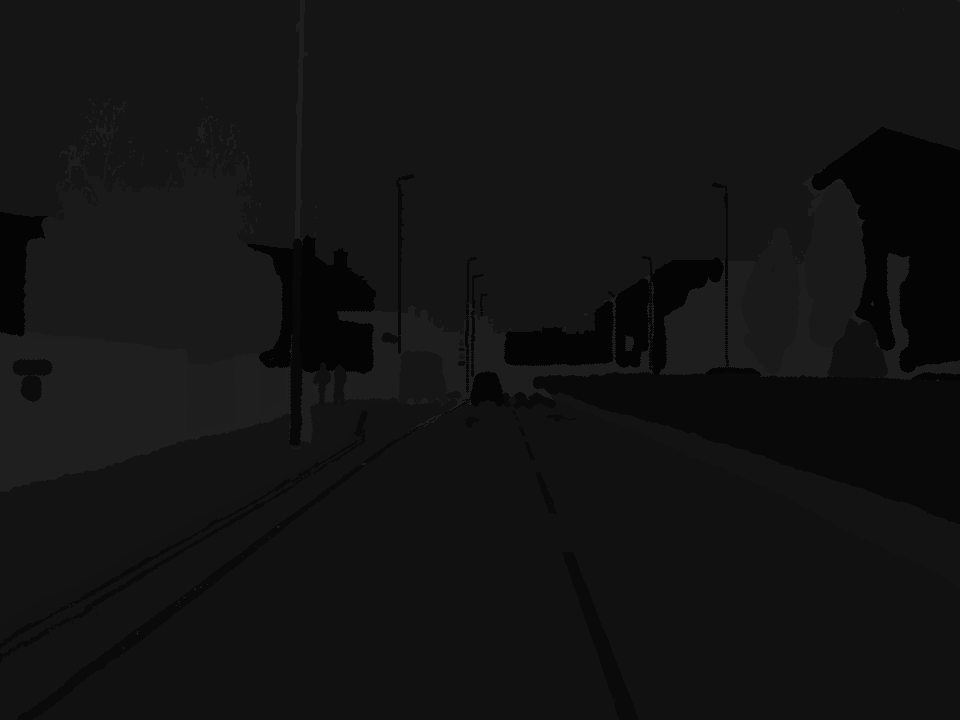

In [9]:
lbl = lbl_path.ls()[1]
fv.PILImage.create(lbl)

In [10]:
i = img_path.ls()[0]

In [11]:
i

Path('/home/mraggi/.fastai/data/camvid/images/0001TP_009990.png')

In [12]:
i.name.replace(".png","_P.png")

'0001TP_009990_P.png'

In [13]:
i.parent.parent / "labels" / i.name.replace(".png","_P.png")

Path('/home/mraggi/.fastai/data/camvid/labels/0001TP_009990_P.png')

In [14]:
lbl_path.ls()[0]

Path('/home/mraggi/.fastai/data/camvid/labels/0001TP_010350_P.png')

In [15]:
def img2label(i):
    return i.parent.parent / "labels" / i.name.replace(".png","_P.png")

In [16]:
def img2label(img):
    return lbl_path/f"{img.stem}_P.png"

In [17]:
img2label(img_path.ls()[8])

Path('/home/mraggi/.fastai/data/camvid/labels/0006R0_f03720_P.png')

In [18]:
img2label(img_path.ls()[8]).exists()

True

In [19]:
!cat {valid_txt}

0016E5_07959.png
0016E5_07961.png
0016E5_07963.png
0016E5_07965.png
0016E5_07967.png
0016E5_07969.png
0016E5_07971.png
0016E5_07973.png
0016E5_07975.png
0016E5_07977.png
0016E5_07979.png
0016E5_07981.png
0016E5_07983.png
0016E5_07985.png
0016E5_07987.png
0016E5_07989.png
0016E5_07991.png
0016E5_07993.png
0016E5_07995.png
0016E5_07997.png
0016E5_07999.png
0016E5_08001.png
0016E5_08003.png
0016E5_08005.png
0016E5_08007.png
0016E5_08009.png
0016E5_08011.png
0016E5_08013.png
0016E5_08015.png
0016E5_08017.png
0016E5_08019.png
0016E5_08021.png
0016E5_08023.png
0016E5_08025.png
0016E5_08027.png
0016E5_08029.png
0016E5_08031.png
0016E5_08033.png
0016E5_08035.png
0016E5_08037.png
0016E5_08039.png
0016E5_08041.png
0016E5_08043.png
0016E5_08045.png
0016E5_08047.png
0016E5_08049.png
0016E5_08051.png
0016E5_08053.png
0016E5_08055.png
0016E5_08057.png
0016E5_08059.png
0016E5_08061.png
0016E5_08063.png
0016E5_08065.png
0016E5_08067.png
0016E5_08069.png
0016E5_08071.png
0016E5_08073.png
0016E5_08075.p

In [20]:
valid_set = set(np.loadtxt(valid_txt,dtype='str'))

In [21]:
valid_set

{'0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png',
 '0016E5_07969.png',
 '0016E5_07971.png',
 '0016E5_07973.png',
 '0016E5_07975.png',
 '0016E5_07977.png',
 '0016E5_07979.png',
 '0016E5_07981.png',
 '0016E5_07983.png',
 '0016E5_07985.png',
 '0016E5_07987.png',
 '0016E5_07989.png',
 '0016E5_07991.png',
 '0016E5_07993.png',
 '0016E5_07995.png',
 '0016E5_07997.png',
 '0016E5_07999.png',
 '0016E5_08001.png',
 '0016E5_08003.png',
 '0016E5_08005.png',
 '0016E5_08007.png',
 '0016E5_08009.png',
 '0016E5_08011.png',
 '0016E5_08013.png',
 '0016E5_08015.png',
 '0016E5_08017.png',
 '0016E5_08019.png',
 '0016E5_08021.png',
 '0016E5_08023.png',
 '0016E5_08025.png',
 '0016E5_08027.png',
 '0016E5_08029.png',
 '0016E5_08031.png',
 '0016E5_08033.png',
 '0016E5_08035.png',
 '0016E5_08037.png',
 '0016E5_08039.png',
 '0016E5_08041.png',
 '0016E5_08043.png',
 '0016E5_08045.png',
 '0016E5_08047.png',
 '0016E5_08049.png',
 '0016E5_08051.png',
 '0016E5_0805

In [22]:
!cat {codes_txt}

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence
LaneMkgsDriv
LaneMkgsNonDriv
Misc_Text
MotorcycleScooter
OtherMoving
ParkingBlock
Pedestrian
Road
RoadShoulder
Sidewalk
SignSymbol
Sky
SUVPickupTruck
TrafficCone
TrafficLight
Train
Tree
Truck_Bus
Tunnel
VegetationMisc
Void
Wall


In [23]:
codes = np.loadtxt(codes_txt,dtype='str')

In [24]:
fv.RandomResizedCropGPU??

Init signature:
fv.RandomResizedCropGPU(
    self,
    size,
    min_scale=0.08,
    ratio=(0.75, 1.3333333333333333),
    mode='bilinear',
    valid_scale=1.0,
    max_scale=1.0,
    mode_mask='nearest',
    **kwargs,
)
Source:        
class RandomResizedCropGPU(RandTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx,order = None,30
    def __init__(self, 
        size, # Final size, duplicated if one value is specified
        min_scale=0.08, # Minimum scale of the crop, in relation to image area
        ratio=(3/4, 4/3), # Range of width over height of the output
        mode='bilinear', # PyTorch `F.grid_sample` interpolation
        valid_scale=1., # Scale of the crop for the validation set, in relation to image area
        max_scale=1., # Maximum scale of the crop, in relation to image area
        mode_mask='nearest', # Interpolation mode for `TensorMask`
        **kwargs
    ):
        if isinstance(size, int): size = (size,size)
    

In [25]:
with open(codes_txt) as f:
    codes = f.readlines()
    codes = [s.strip() for s in codes]

In [26]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size)
    
    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.MaskBlock(codes=codes)),
                        get_items = fv.get_image_files,
                        get_y     = img2label,
                        splitter  = fv.FuncSplitter(lambda x: x.name in valid_set),
                        item_tfms = fv.Resize(2*img_size),
                        batch_tfms= tfms,
                       )
    return data.dataloaders(folder, bs=batch_size)

In [27]:
data = load_data(img_path,512,4)

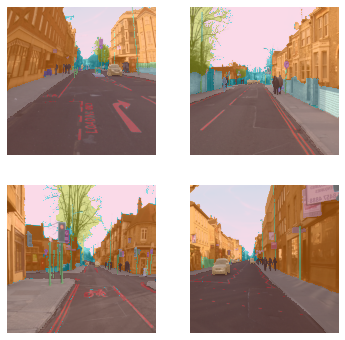

In [28]:
data.show_batch()

In [29]:
len(codes)

32

In [30]:
from Layers import abc,cab

In [31]:
model = nn.Sequential(
    *cab(3,16,s=2),
    *cab(16,16),
    *cab(16,32,s=2),
    *cab(32,32),
    *cab(32,64,s=2),
    *cab(64,64),
    *cab(64,96,s=2),
    *cab(96,96),
    fv.PixelShuffle_ICNR(96,64),
    *cab(64,64),
    fv.PixelShuffle_ICNR(64,48),
    *cab(48,48),
    fv.PixelShuffle_ICNR(48,32),
    *cab(32,32),
    fv.PixelShuffle_ICNR(32,32),
    nn.Conv2d(32,32,kernel_size=3,padding=1)
).cuda()

In [32]:
def seg_accuracy(yp, y):
    correct = (yp.argmax(dim=1) == y)
    return correct.float().mean()

In [33]:
x,y = data.one_batch()

In [34]:
x.shape

torch.Size([4, 3, 512, 512])

In [35]:
y.shape

torch.Size([4, 512, 512])

In [36]:
model(x).shape

torch.Size([4, 32, 512, 512])

In [37]:
learn = fv.Learner(data,
                   model,
                   opt_func=fv.ranger,
                   metrics=seg_accuracy)

In [ ]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(3,1e-2,div=1,pct_start=0.7)

epoch,train_loss,valid_loss,seg_accuracy,time
0,1.260733,2.146352,0.396310,00:16
1,1.174060,1.186439,0.612694,00:16
2,0.990195,0.932898,0.736055,00:16


## UNET

Bueno, ya que entendimos el modelo y el proceso, simplemente ahora hay que tomar un modelo apropiado.

El problema es que cada pixel tiene campo de visión muy pequeño. Es decir, ahora tenemos 5 capas nada más, cada una con kernel size de 3. Para decidir qué es un pixel, entonces, vemos SOLO 5 pixeles hacia cada dirección! (cada capita ve un pixel más).

Eso no tiene mucho sentido, así que haremos algo más como autoencoder (es decir, reducir el tamaño y luego volver a explotar). ¿Por qué? Cuando reduces el tamaño, el campo de visión de cada convolución aumenta!!

Pero después se les ocurrió (a unos biólogos!) que por qué no darle a la red neuronal la imagen original para trabajar una vez que ya obtuvo información semántica de ella?

Entonces inventaron la UNET:

![](unet.png)

La podríamos construir a mano, PERO fastai ya trae una función para construirla en base a una arquitectura:

In [ ]:
data.train.bs = 16
data.valid.bs = 16

In [ ]:
fv.resnet18??

In [ ]:
def res_mia(pretrained=False, progress=True, **kwargs):
    modelo = fv._resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,**kwargs)
    modelo.load_state_dict('una_que_tu_preeentrenaste_en_amazon_planet.pth')
    return modelo

In [ ]:
res_mia()

In [ ]:
learn = fv.unet_learner(data,fv.resnet18,normalize=False,opt_func=fv.ranger,metrics=seg_accuracy)

In [ ]:
learn.summary()

In [ ]:
gc.collect()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20,1e-3,div=1,pct_start=0.7)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10,slice(1e-5,1e-4),div=1,pct_start=0.7)

In [ ]:
learn.show_results()